In [ ]:
folder = '/content/data'

# Load libraries

import numpy as np
import scipy
from scipy.ndimage import convolve1d
from scipy.io.wavfile import read, write
import matplotlib.pyplot as plt
import os
import sys
import math

import librosa
import librosa.display

In [ ]:
dataset_path = '/content/data'
json_path = "data.json"


def save_chroma(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=25, segment_length = 0.5):

    data = {
        "mapping": [],
        "labels": [],
        "chroma": []
    }

    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(folder)):
            #print(dirpath)
            # ensure we're processing a genre sub-folder level
            #print(dataset_path)
            if dirpath != dataset_path:
                
                # save genre label (i.e., sub-folder name) in the mapping
                semantic_label = dirpath.split("/")[-1]
                if semantic_label[0] == '.':
                  continue
                
                data['mapping'].append(semantic_label)
                #print("\nProcessing: {}".format(semantic_label))

                # process all audio files in genre sub-dir
                for f in filenames:

                    # load audio file
                    file_path = os.path.join(dirpath, f)
                    sr, signal = read(file_path)
                    #signal, sr = librosa.load(file_path, sr=None)
                    #signal = signal[:,1]

                    y = signal[:,1].astype(np.float32)
                    signal = y/np.abs(y).max()/2

                    track_duration = signal.size/sr # measured in seconds
                    num_segments = int(track_duration / segment_length)
                    samples_per_track = sr * track_duration
                    samples_per_segment = int(samples_per_track / num_segments)
                    num_chroma_vectors_per_segment = math.ceil(samples_per_segment / hop_length)
                    #print(f, track_duration, num_mfcc_vectors_per_segment)

                    # process all segments of audio file
                    for d in range(num_segments):

                        # calculate start and finish sample for current segment
                        start = samples_per_segment * d
                        finish = start + samples_per_segment
                        # print(start, finish, samples_per_segment)
                        # extract chroma
                        chroma = librosa.feature.chroma_cqt(y=signal[start:finish], sr=sr, hop_length=hop_length)
                        # print(signal[start:finish].shape)


                        ## extract mfcc
                        #mfcc = librosa.feature.mfcc(signal[start:finish], sr, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                        #mfcc = mfcc.T
                        
                        #print(chroma)
                        
                        # print(chroma.shape)
                        # print(chroma[:,:44].shape)
                        

                        # data["chroma"].append(chroma.tolist())
                        data["chroma"].append(chroma[:,:44].tolist())
                        # print(chroma[:,:44].shape)
                        data["labels"].append(i-1)
                        #print("{}, segment:{}".format(file_path, d+1))

    # save MFCCs to json file
    # with open(json_path, "w") as fp:
    #   json.dump(data, fp, indent=4)    
    return data           

In [ ]:
data = save_chroma(dataset_path, json_path)

In [ ]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt

DATA_PATH = "data.json"

def load_data_file(data):
    """Loads training dataset from json file.
        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    # with open(data_path, "r") as fp:
    #     data = json.load(fp)
    
    X_temp = np.array(data["chroma"])
    X = np.empty([X_temp.shape[0], 12, 44])
    for i in range(X.shape[0]):
      X[i] = np.vstack((X_temp[i]))
    y = np.array(data["labels"])
    return X, y


def load_data(data_path):
    """Loads training dataset from json file.
        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["chroma"])
    for i in range(X.shape[0]):
      X[i] = np.vstack((X[i]))
    y = np.array(data["labels"])
    return X, y


def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()


def prepare_datasets(test_size, validation_size, data):
    """Loads data and splits it into train, validation and test sets.
    :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
    :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split
    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    :return y_train (ndarray): Target training set
    :return y_validation (ndarray): Target validation set
    :return y_test (ndarray): Target test set
    """

    # load data
    X, y = load_data_file(data)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test


def build_model(input_shape):
    """Generates CNN model
    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """

    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model


def predict(model, X, y):
    """Predict a single sample using the trained model
    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 10, 42, 32)        320       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 5, 21, 32)         0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 5, 21, 32)         128       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 3, 19, 32)         9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 2, 10, 32)         0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 2, 10, 32)         128       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 1, 9, 32)         

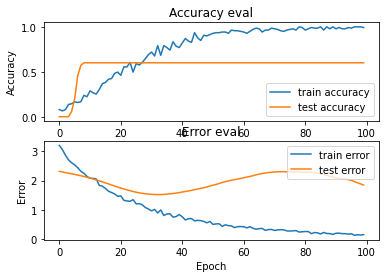

2/2 - 0s - loss: 2.5025 - accuracy: 0.5000

Test accuracy: 0.5
Target: 2, Predicted label: [2]


In [ ]:
# get train, validation, test splits
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2, data)

# create network
input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = build_model(input_shape)

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# train model
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=100)

# plot accuracy/error for training and validation
plot_history(history)

# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

# pick a sample to predict from the test set
X_to_predict = X_test[50]
y_to_predict = y_test[50]

# predict sample
predict(model, X_to_predict, y_to_predict)